In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib as mpl
import xarray as xr
import pylab as plt
mpl.rc('figure', figsize=(10,10),facecolor='white', dpi=300)
mpl.rc('figure.subplot', wspace= 0.4, hspace=0.2)
mpl.rc('figure.subplot', hspace= 0.2)
mpl.rc('axes', grid=1, titlesize=14)
mpl.rc('axes.formatter',limits=(-2,5))
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
def area_grid(lat,lon):
    '''
    Function to calculate surface area per gridbox
    Units: m2
    S = R^2*(lon2-lon1)*(sin lat2 - sin lat1)
    lon in radians, R = 6371 km
    '''
    import numpy as np
    Pi           = np.float128(3.141592653589793238462643383279)
    Earth_Radius = np.float128(6371.0*1.0E3)#equator radius:6378.1*1E3
    lat_bound    = np.float128(89.999999999999999999999999)
    lon          = np.float128(lon)
    lat          = np.float128(lat)
    rlon         = (lon[:]/np.float128(180.0))*Pi
    rlat         = (lat[:]/np.float128(180.0))*Pi
    dlat         = (rlat[1] - rlat[0])/2.0
    dlon         = (rlon[1] - rlon[0])/2.0
    #
    area = np.zeros((len(rlat),len(rlon)),np.float128)
    j=0
    while j < len(rlat):
        if (lat[j] >= lat_bound):
            lat1 = rlat[j]
            lat2 = rlat[j] - dlat/2.0
        elif (lat[j] <= -1.0*lat_bound):
            lat1 = rlat[j] + dlat/2.0
            lat2 = rlat[j]
        else:
            lat1 = rlat[j] + dlat
            lat2 = rlat[j] - dlat
        i=0
        while i < len(rlon):
            lon1 = rlon[i] - dlon
            lon2 = rlon[i] + dlon
            area[j,i] = (Earth_Radius**2)*(abs(np.sin(lat1)-np.sin(lat2))*abs(lon1-lon2))
            i += 1
        j += 1
    return area

In [3]:
#%%
import socket
print(socket.gethostname())
#%%

jupyter-ptg21


In [4]:
def calc_o3col(o3file, airmassfile, start_date='1995-01-01', end_date='2015-01-01'):
    ncdata = xr.open_dataset(o3file)
    lat = ncdata.latitude
    lon = ncdata.longitude
    #lon = ncdata.variables['longitude'][:]
    o3 = ncdata.o3.sel(time=slice(start_date, end_date))

    ncdata = xr.open_dataset(airmassfile)
    lat = ncdata.latitude
    lon = ncdata.longitude
    tropairmass = ncdata.aimass_trop.sel(time=slice(start_date, end_date))

    #o3 = o3.where(o3*28.8/48<125e-9,o3,0)
    o3 = o3*tropairmass
    colo3 = o3.sum(dim='model_level_number')

    gridcellarea=area_grid(o3.latitude.data, o3.longitude.data)
    ozonecolumn = np.empty_like(colo3.data)
    for ivar in range (0,len(o3.time)):
        ozonecolumn[ivar,:,:] = colo3.data[ivar,:,:]/gridcellarea

    ozonecolumn_in_DU=ozonecolumn/0.048*6.02e23/2.69e20
    ozonecolumn_in_DU = xr.DataArray(ozonecolumn_in_DU,
                            coords=[o3.time, o3.latitude, o3.longitude],
                            dims=['time', 'latitude', 'longitude'])
    return ozonecolumn_in_DU

In [5]:
cb159col = calc_o3col('/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_1995-2010_o3_monthly.nc',
                      '/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_1995-2010_trop_air_mass_monthly.nc',
                      '1995-01-01', '2015-01-01')

In [6]:
cq029col = calc_o3col('/gws/nopw/j04/htap2/ptg21/u-cq029/u-cq029_o3_monthly.nc',
                      '/gws/nopw/j04/htap2/ptg21/u-cq029/u-cq029_trop_air_mass.nc',
                      '1995-01-01', '2015-01-01')

In [7]:
cq041col = calc_o3col('/gws/nopw/j04/htap2/ptg21/u-cq041/u-cq041_o3_monthly.nc',
                      '/gws/nopw/j04/htap2/ptg21/u-cq041/u-cq041_trop_air_mass_monthly.nc',
                      '1995-01-01', '2015-01-01')

In [8]:
omi = nc.Dataset('/gws/nopw/j04/ukca_vol2/ptg21/observations/OMI/OMI_trop_O3_2005.nc')
omi_lat = omi['latitude'][:]
omi_lon = omi['longitude'][:]
omi_o3 = omi['O3'][:]
omi_o3 = omi_o3/10.


/tmp/ipykernel_513/227264722.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])


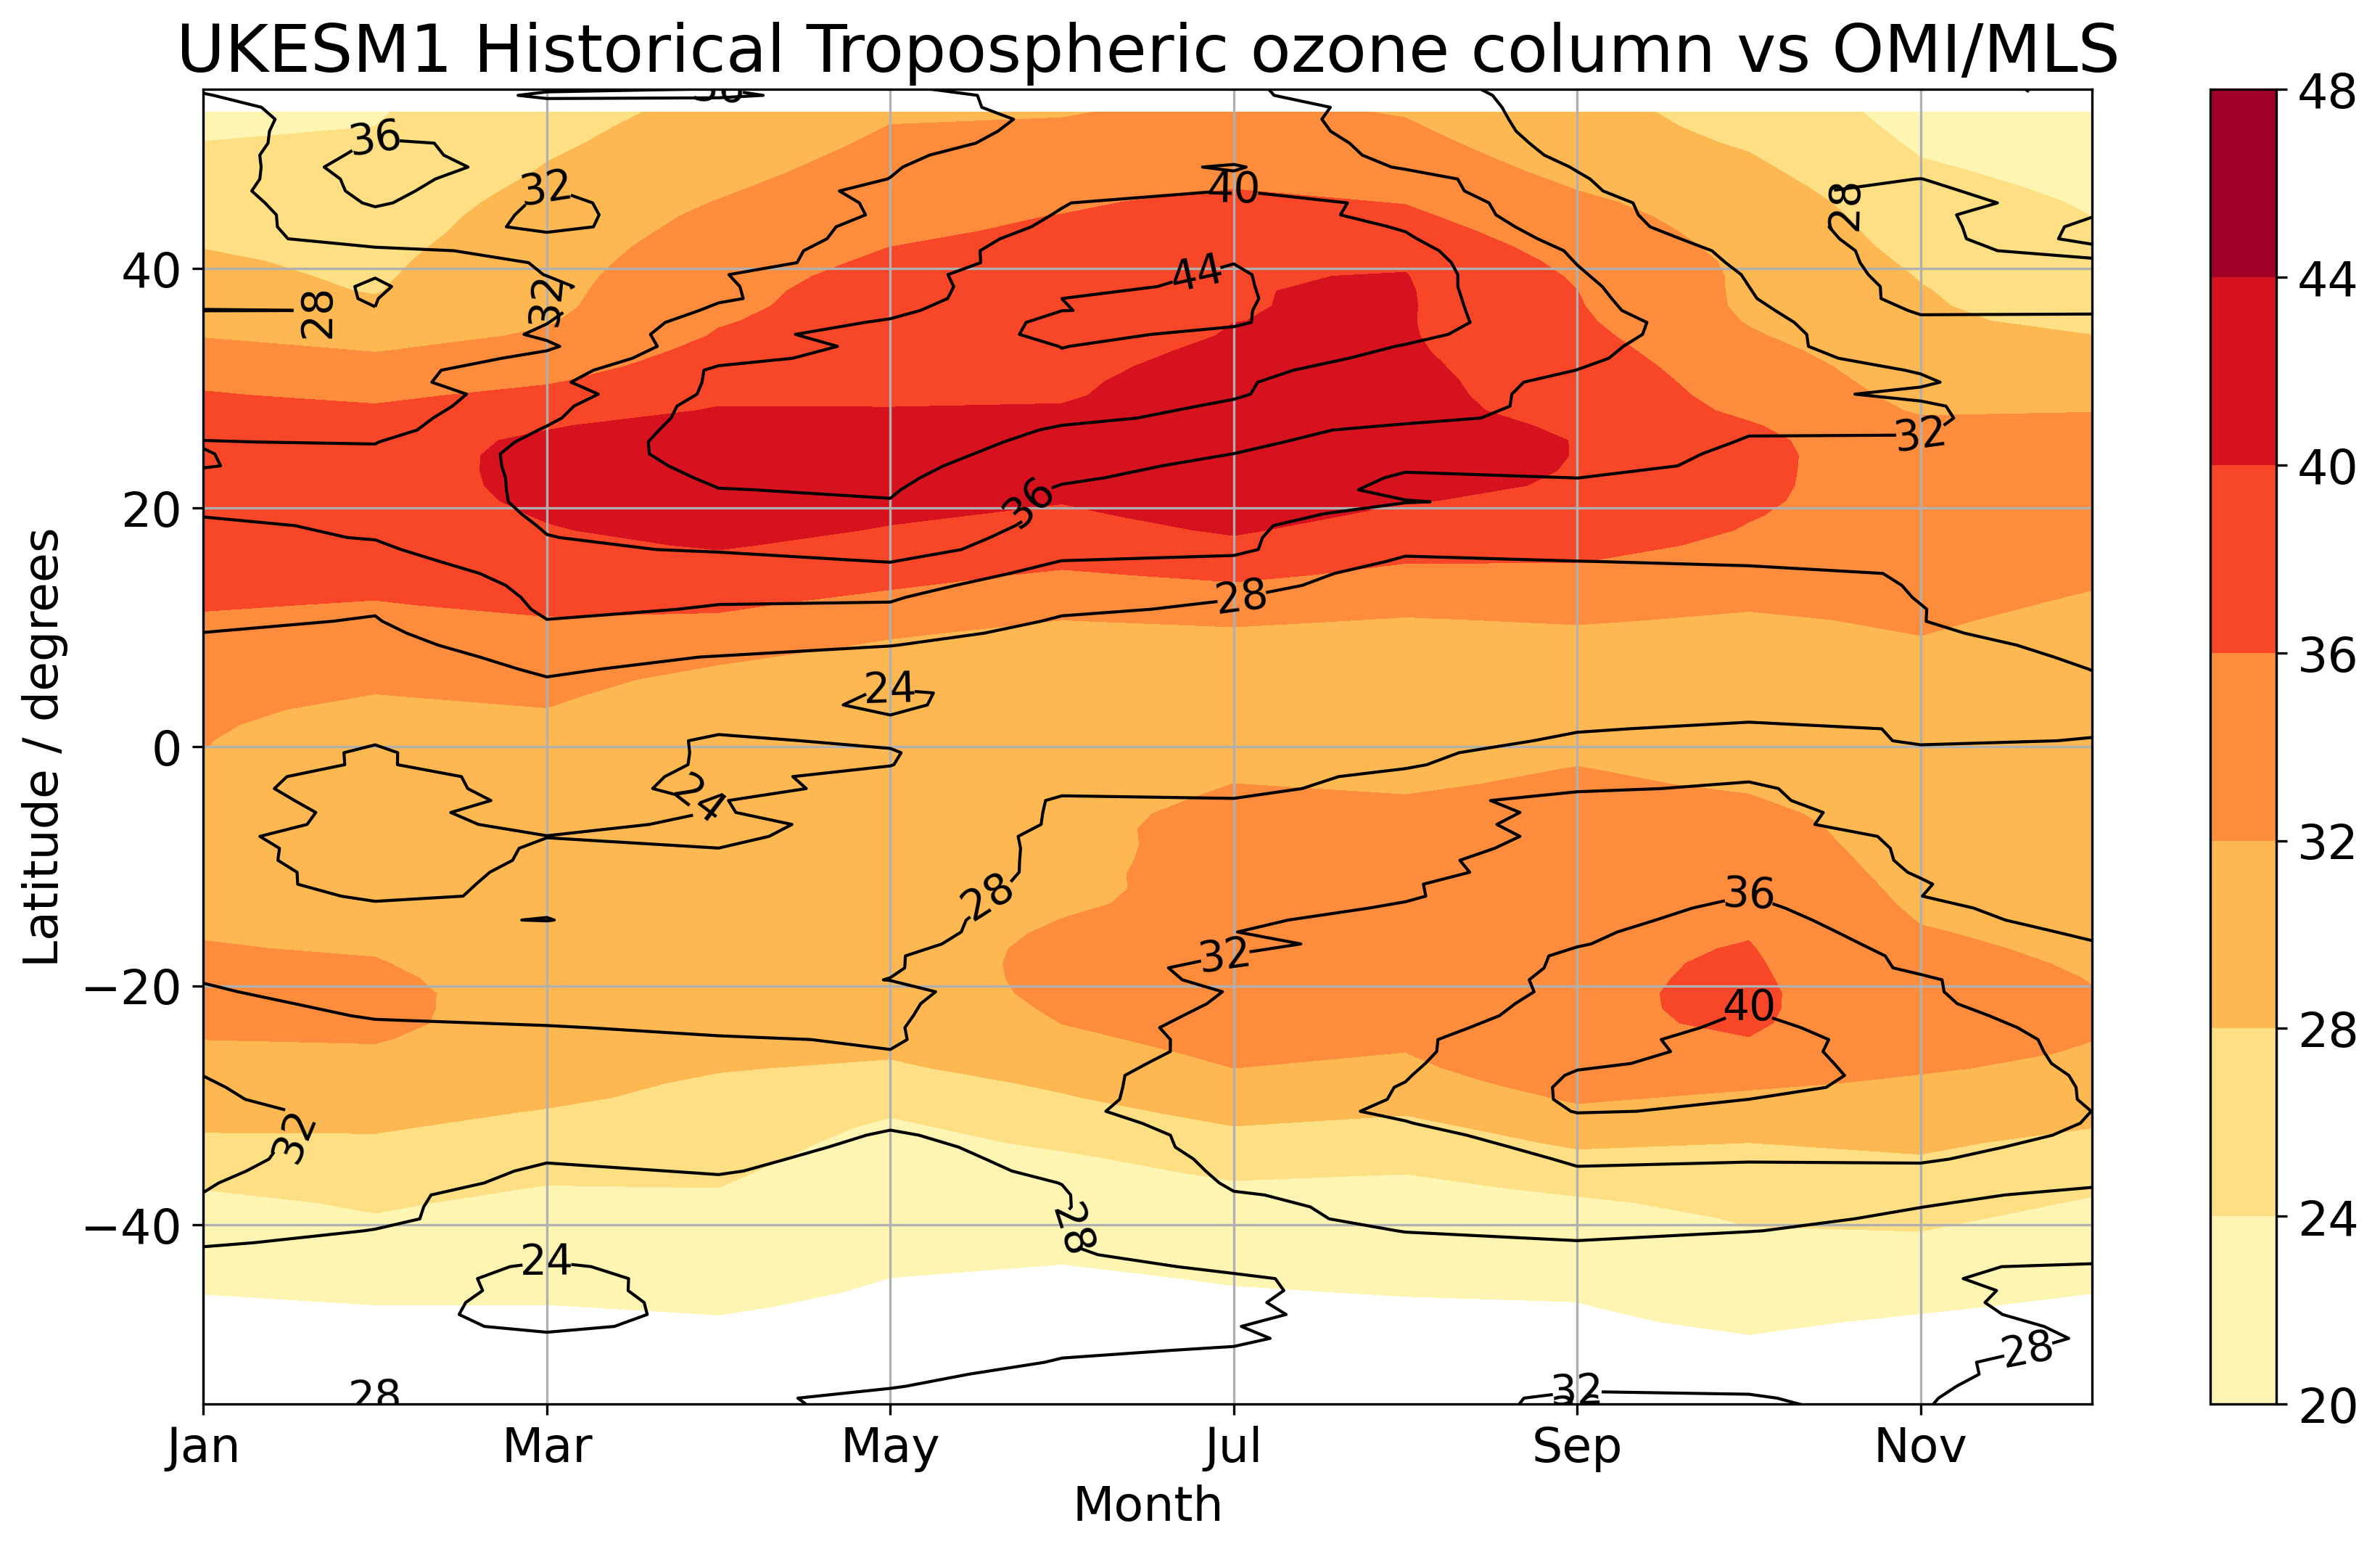

<Figure size 3000x3000 with 0 Axes>

In [9]:

lonbounds = [ -180, 180]
latbounds = [ -55, 55 ] # degrees east ?
lat = cb159col.latitude.data[:]
# latitude lower and upper index
latli = np.argmin( np.abs( cb159col.latitude.data - latbounds[0] ) )
latui = np.argmin( np.abs( cb159col.latitude.data - latbounds[1] ) )

fig,ax = plt.subplots(figsize=(14, 8),dpi=300)
cs1= plt.contourf( np.arange(0,12), 
                  lat.data[latli:latui], 
                  np.transpose(np.mean(cb159col.data[-12:,latli:latui,:],axis=2)),
                levels=np.arange(20,52,4), cmap=plt.cm.YlOrRd)
cs2 = plt.contour(np.arange(0,12), 
                  omi_lat, 
                  np.transpose(np.mean(omi_o3.data[-12:,:,:],axis=2)),
                  colors='black',levels=np.arange(20,52,4),linewidths=1)
plt.clabel(cs2, fontsize=14, fmt='%2.0f')
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])
ax.set_ylabel('Latitude / degrees')
ax.set_xlabel('Month')
ax.set_ylim((latbounds[0], latbounds[1]))
plt.colorbar(cs1)
plt.title('UKESM1 Historical Tropospheric ozone column vs OMI/MLS', fontsize=22)
plt.show()
plt.savefig('u-cb159_trop_o3_col_vs_OMI_mls.png')

In [10]:
#%%


print('min ', np.min(cb159col[:]))


#%%


print('max ', np.max(cb159col[:]))


#%%


print('mean ', np.mean(cb159col[:]))


# In[ ]:

min  <xarray.DataArray ()>
array(3.1849782, dtype=float32)
max  <xarray.DataArray ()>
array(71.692215, dtype=float32)
mean  <xarray.DataArray ()>
array(25.764198, dtype=float32)


In [11]:
import cartopy.crs as ccrs

In [12]:
def make_map(bbox, projection=ccrs.PlateCarree(central_longitude=0)):
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    # x0, x1, y0, y1
    #ax.add_feature(LAND, facecolor='white')
    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, color='gray')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


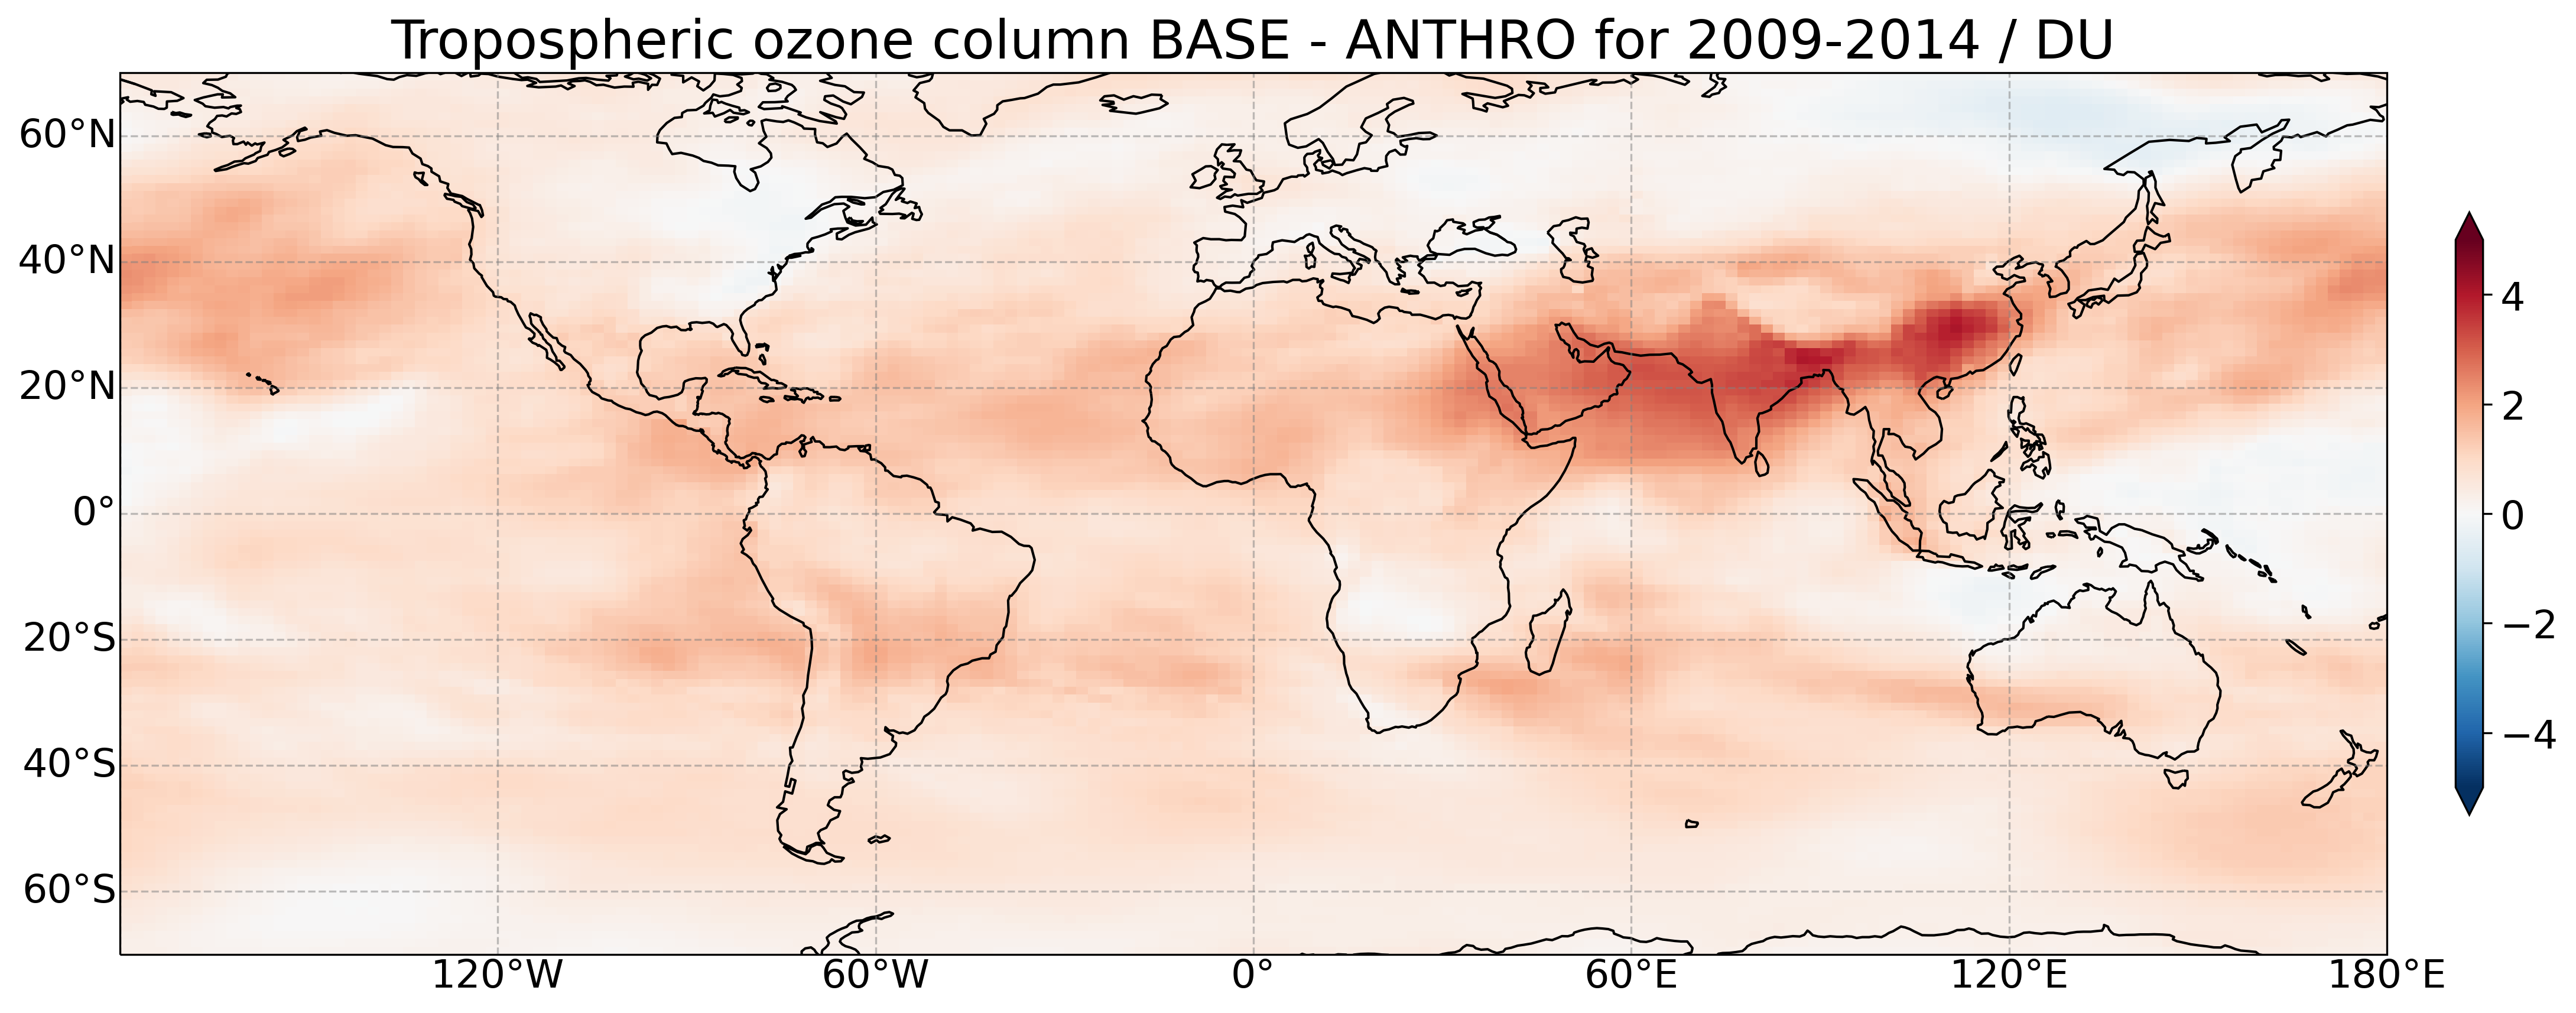

In [28]:
ANTHRO_MIN_BASE = (cq029col.resample(time='1Y').mean(dim='time')-cb159col.resample(time='1Y').mean(dim='time'))[5:]

bbox=[-179, 179, -70, 70]
x,y = ANTHRO_MIN_BASE.longitude,ANTHRO_MIN_BASE.latitude
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(x, y, -ANTHRO_MIN_BASE.mean(dim='time').data, vmin=-5, vmax=5, cmap='RdBu_r')
cbar = fig.colorbar(cs, orientation='vertical', shrink=0.45,extend='both', pad=0.025 )
plt.title('Tropospheric ozone column BASE - ANTHRO for 2009-2014 / DU', fontsize=22)
plt.show()


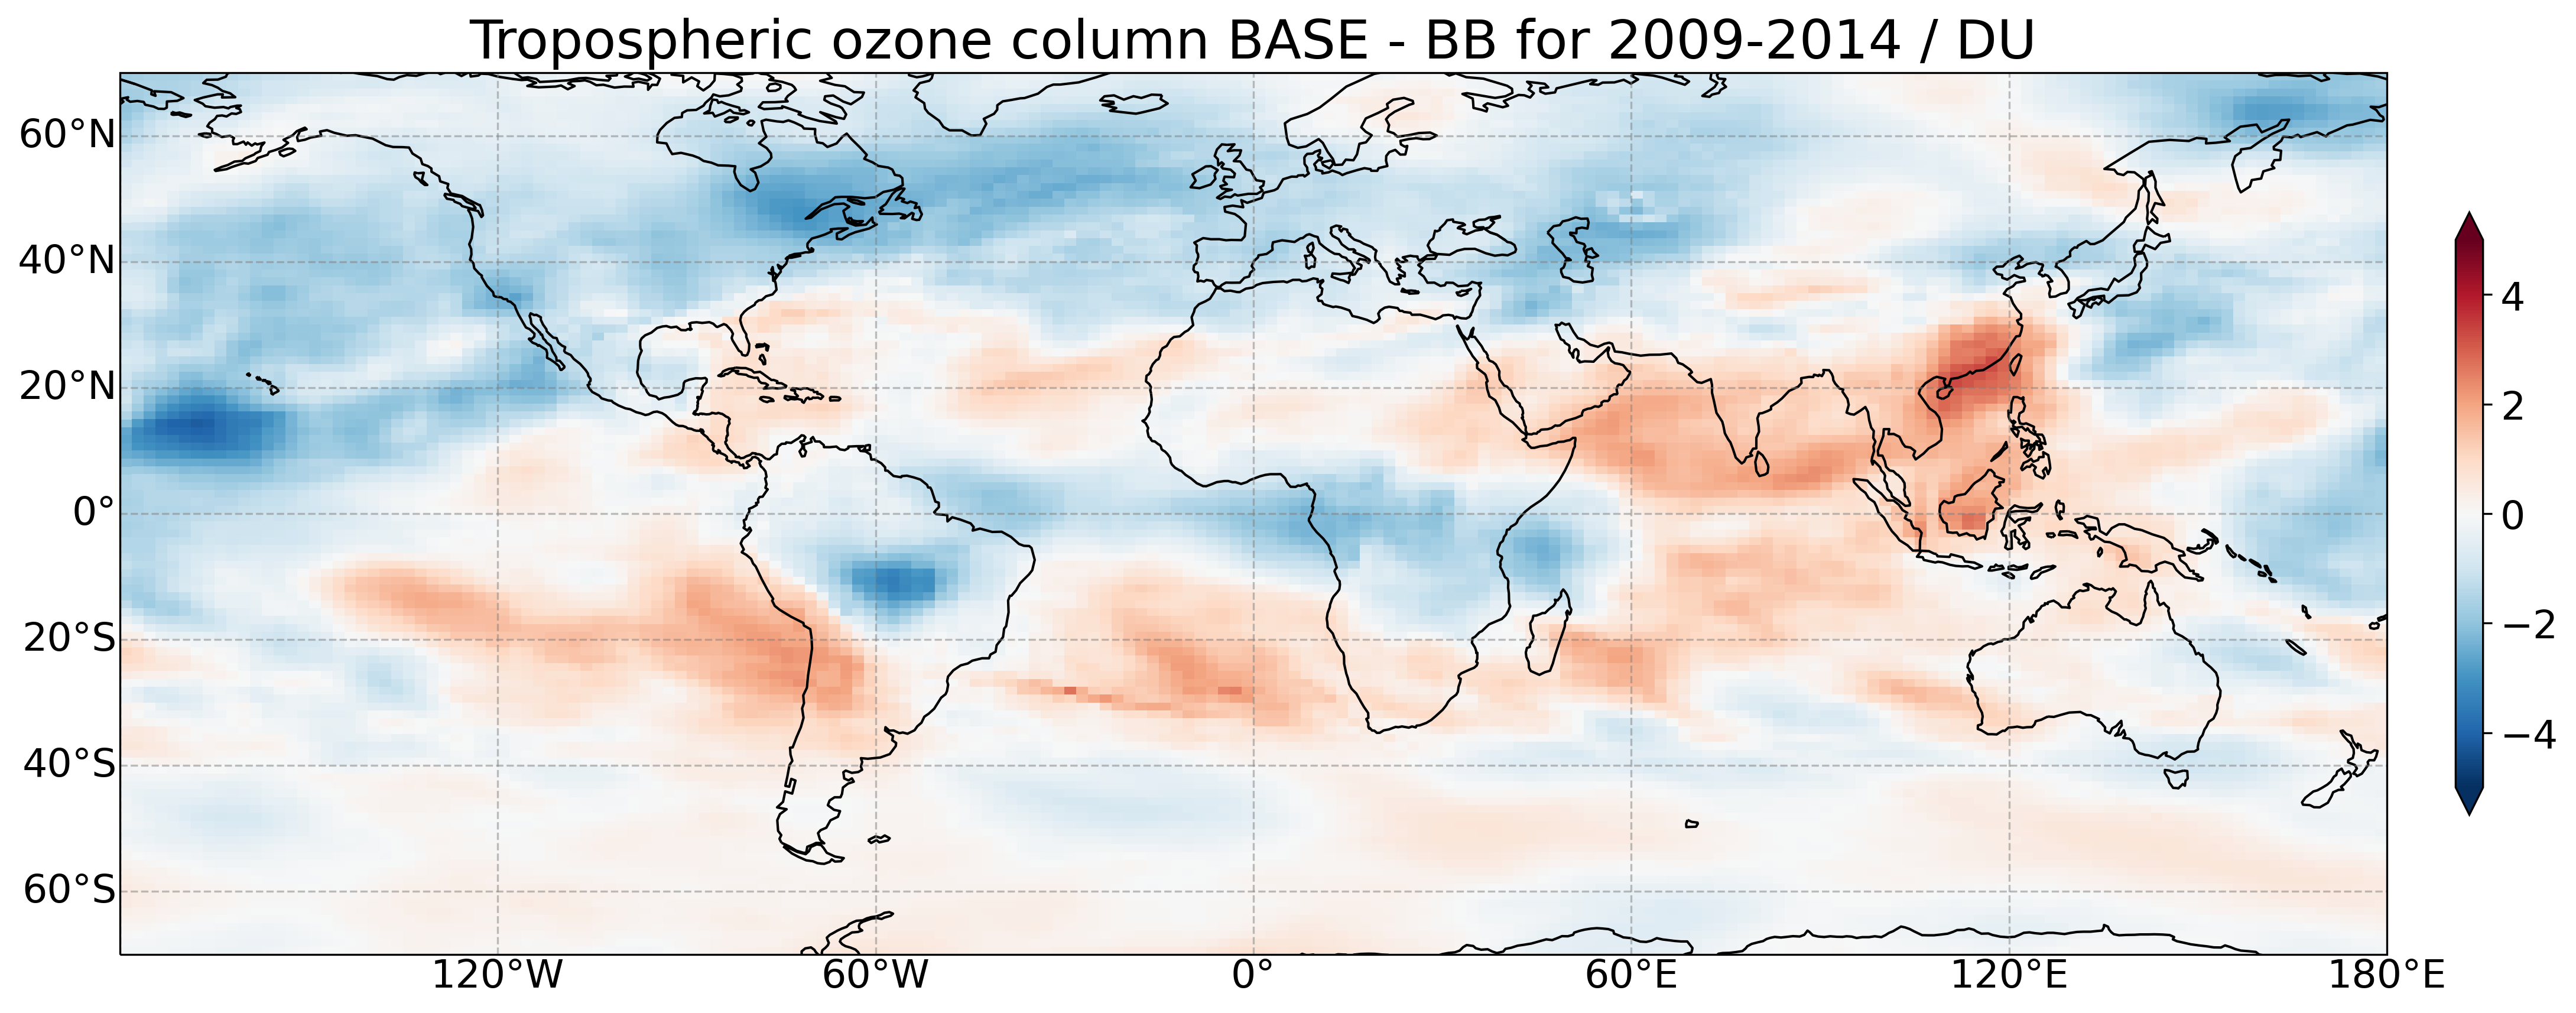

In [27]:
BB_MIN_BASE = cq041col.resample(time='1Y').mean(dim='time')[-5:] - cb159col.resample(time='1Y').mean(dim='time')[-5:]

bbox=[-179, 179, -70, 70]
x,y = BB_MIN_BASE.longitude,BB_MIN_BASE.latitude
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(x, y, -BB_MIN_BASE.mean(dim='time').data, vmin=-5, vmax=5, cmap='RdBu_r')
cbar = fig.colorbar(cs, orientation='vertical', shrink=0.45,extend='both', pad=0.025 )
plt.title('Tropospheric ozone column BASE - BB for 2009-2014 / DU', fontsize=22)
plt.show()


In [23]:
import netCDF4 as nc
import pylab as plt
import numpy as np
results = np.empty([1,2])
o3 = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_o3.nc')
airmass = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_trop_air_mass.nc')
BASEtropo3 = (o3.o3*airmass.aimass_trop).sum(dim=['model_level_number','latitude','longitude'])
BASEtropo3 = BASEtropo3.resample(time='1Y').mean()
BASEtropo3 = BASEtropo3.to_dataframe(name='O3 Burden')

o3 = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq029/u-cq029_o3_monthly.nc')
airmass = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq029/u-cq029_trop_air_mass.nc')
ANTRHOtropo3 = (o3.o3*airmass.aimass_trop).sum(dim=['model_level_number','latitude','longitude'])
ANTRHOtropo3 = ANTRHOtropo3.resample(time='1Y').mean()
ANTRHOtropo3 = ANTRHOtropo3.to_dataframe(name='O3 Burden')


o3 = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq041/u-cq041_o3_monthly.nc')
airmass = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq041/u-cq041_trop_air_mass_monthly.nc')
BBtropo3 = (o3.o3*airmass.aimass_trop).sum(dim=['model_level_number','latitude','longitude'])
BBtropo3 = BBtropo3.resample(time='1Y').mean()
BBtropo3 = BBtropo3.to_dataframe(name='O3 Burden')

In [24]:
ANTRHOtropo3

,O3 Burden
time,
1995-12-30 00:00:00,3.072369e+11
1996-12-30 00:00:00,3.011600e+11
1997-12-30 00:00:00,3.124358e+11
1998-12-30 00:00:00,3.321495e+11
1999-12-30 00:00:00,3.256252e+11
2000-12-30 00:00:00,3.129342e+11
2001-12-30 00:00:00,3.097609e+11
2002-12-30 00:00:00,3.040327e+11
2003-12-30 00:00:00,3.108010e+11


In [18]:
o3 = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq393/u-cq393_o3_monthly.nc')
airmass = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cq393/u-cq393_trop_air_mass_monthly.nc')
ANTHRO_T_tropo3 = (o3.o3*airmass.aimass_trop).sum(dim=['model_level_number','latitude','longitude'])
ANTHRO_T_tropo3 = ANTHRO_T_tropo3.resample(time='1Y').mean()
ANTHRO_T_tropo3 = ANTHRO_T_tropo3.to_dataframe(name='O3 Burden')

In [20]:
ANTHRO_T_tropo3

,O3 Burden
time,
1995-12-30 00:00:00,3.072368e+11
1996-12-30 00:00:00,3.078957e+11
1997-12-30 00:00:00,3.135125e+11
1998-12-30 00:00:00,3.237035e+11
1999-12-30 00:00:00,3.236781e+11
2000-12-30 00:00:00,3.146801e+11
2001-12-30 00:00:00,3.079679e+11
2002-12-30 00:00:00,3.134518e+11
2003-12-30 00:00:00,3.168050e+11


In [43]:
import pandas as pd
BASEtropo3.index = pd.date_range(start='1995-06-01', end='2013-06-30', freq='12M')
ANTRHOtropo3.index = pd.date_range(start='1995-06-01', end='2013-06-30', freq='12M')
BBtropo3.index = pd.date_range(start='1995-06-01', end='2013-06-30', freq='12M')
ANTHRO_T_tropo3.index = pd.date_range(start='1995-06-01', end='2014-06-30', freq='12M')

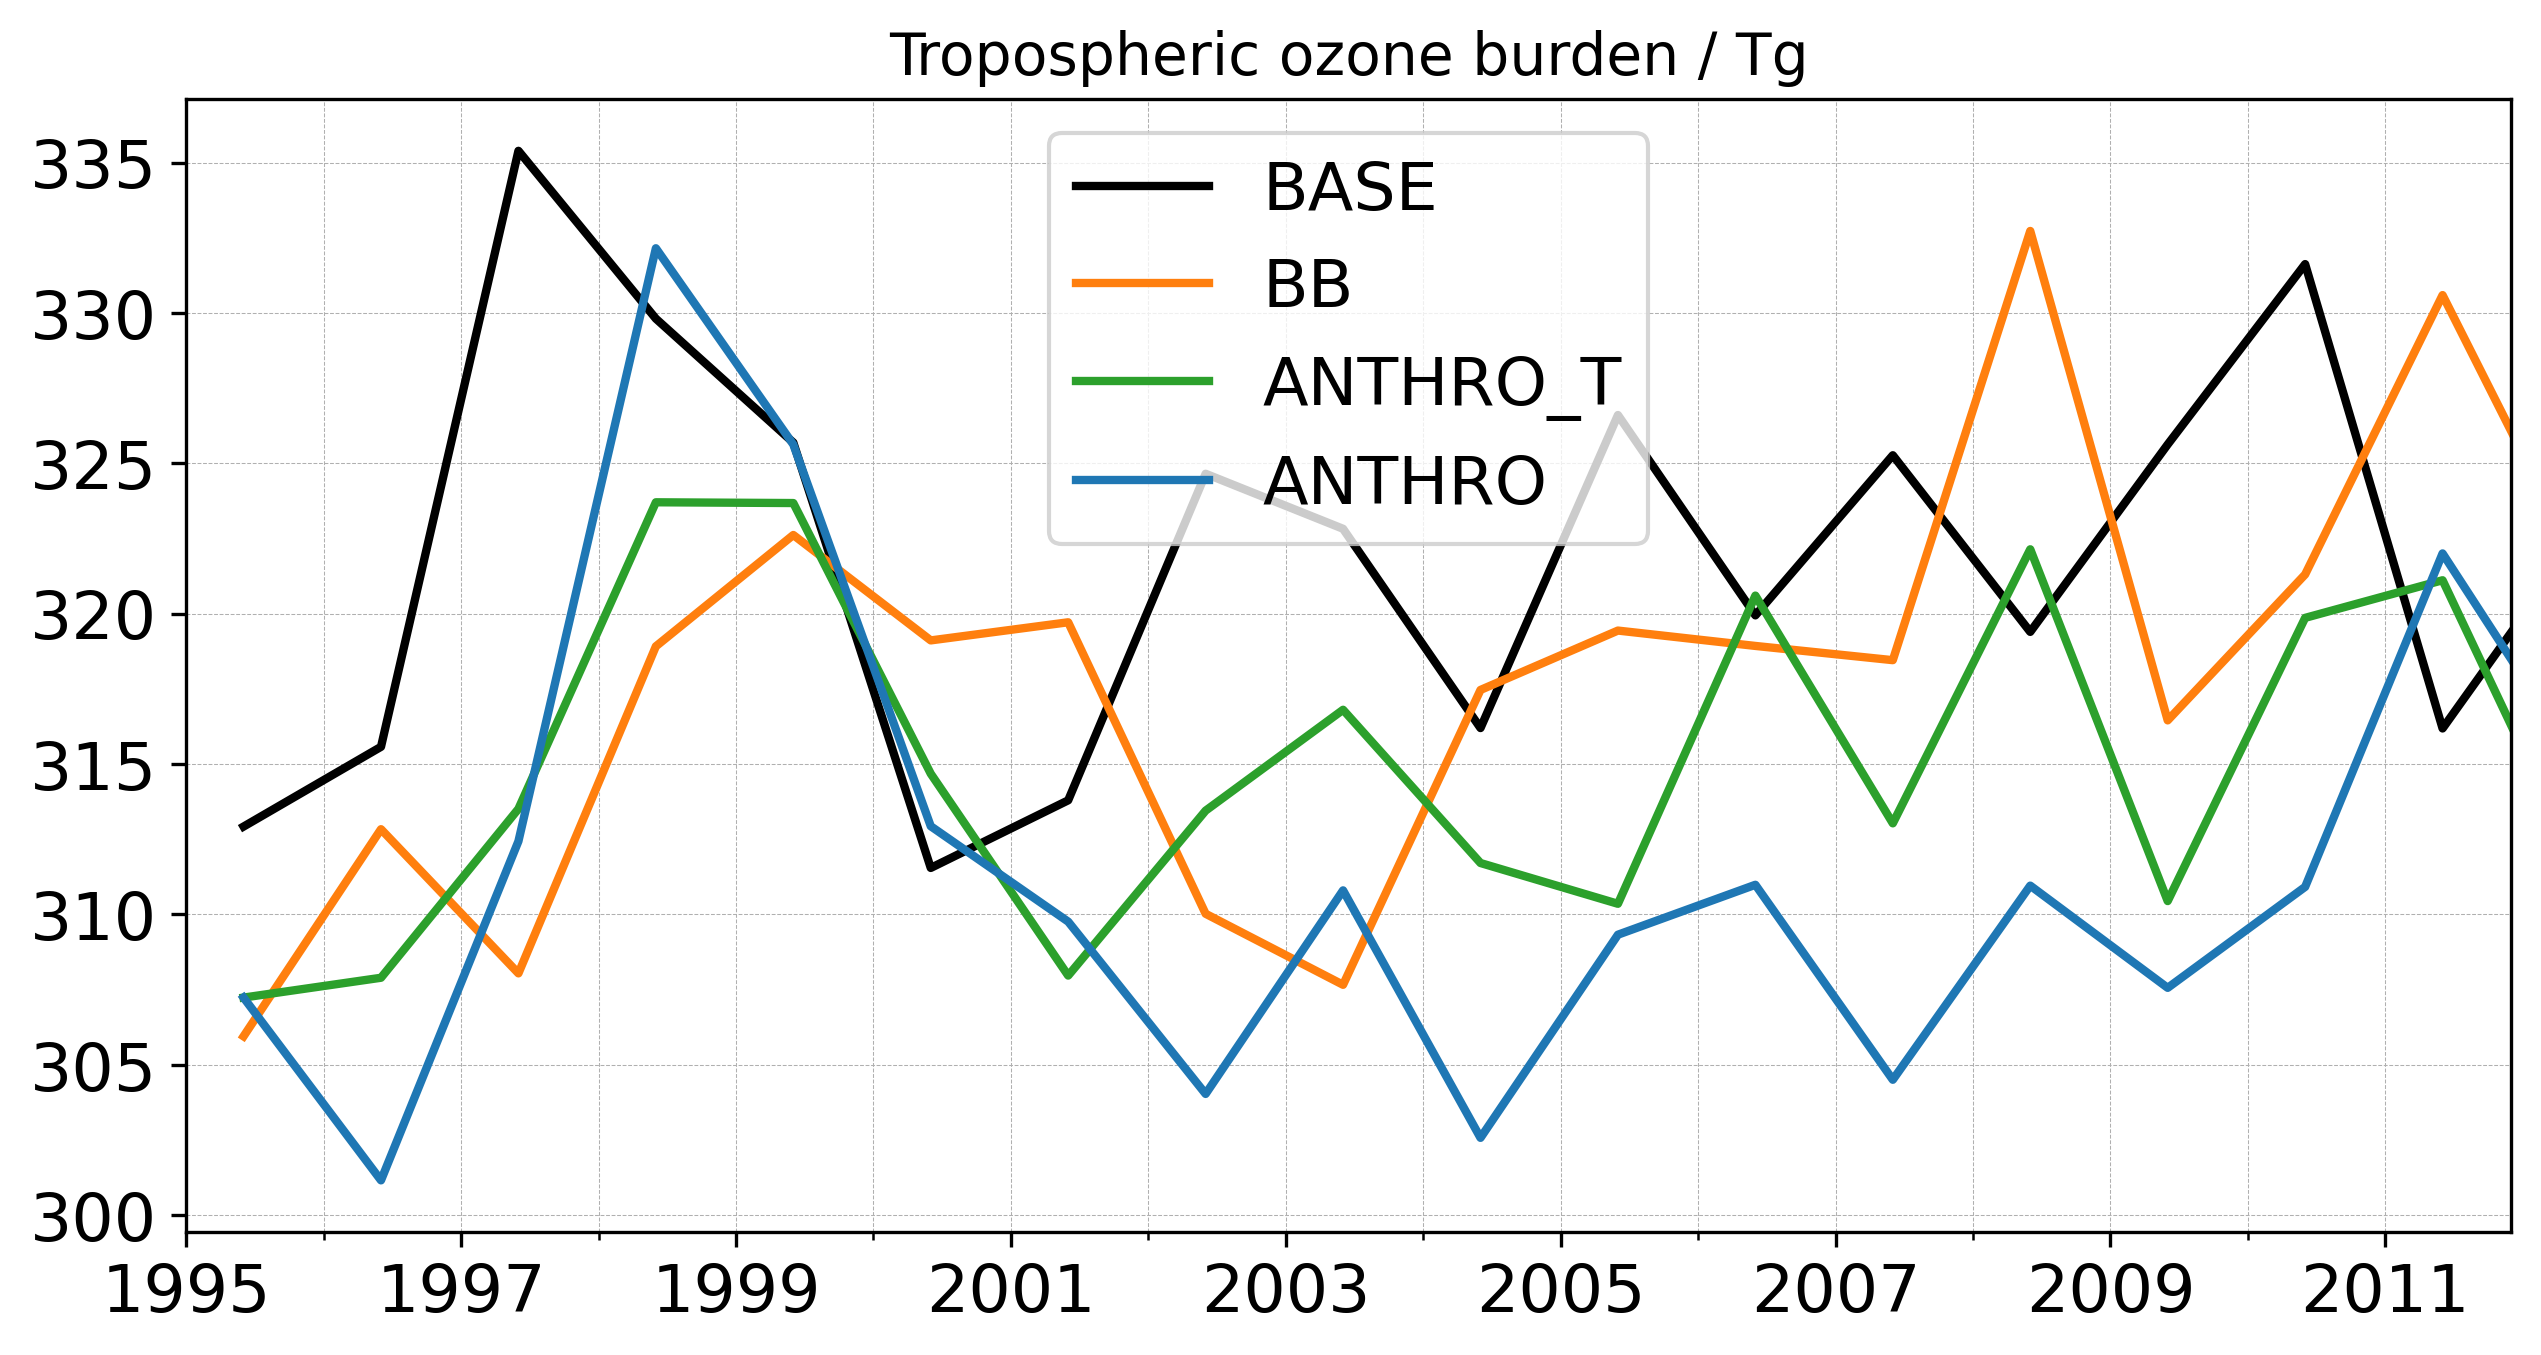

In [44]:
import datetime
cmap = plt.get_cmap("tab10")
fig=plt.figure(figsize=(10,5), dpi=300)
plt.subplot(1,1,1)
ax=(BASEtropo3['O3 Burden']/1e9).plot(color='k', label='BASE')
(BBtropo3['O3 Burden']/1e9).plot(color=cmap(1), label='BB')
(ANTHRO_T_tropo3['O3 Burden']/1e9).plot(color=cmap(2), label='ANTHRO_T')
(ANTRHOtropo3['O3 Burden']/1e9).plot(color=cmap(0), label='ANTHRO')


ax.grid(True, which='both', linestyle='--', linewidth=0.25)
ax.set_xlim([datetime.date(1995, 1, 1), datetime.date(2011, 12, 31)])
plt.title('Tropospheric ozone burden / Tg')
plt.legend()


In [31]:
nox_ems_BASE_BB = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/OPT-emissions/constant_1995_global_bb/NO_biomass_low_1849_2015_time_series.nc')
nox_ems_BASE_BB = nox_ems_BASE_BB.emissions_NO_biomass_low.sel(time=slice('1995-01-01', '2015-01-01'))
gridcellarea = area_grid(nox_ems_BASE_BB.latitude, nox_ems_BASE_BB.longitude)
nox_ems_BASE_BB = nox_ems_BASE_BB*gridcellarea
nox_ems_BASE_BB = nox_ems_BASE_BB.resample(time='1Y').sum()
    
nox_ems_BASE = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/OPT-emissions/constant_1995_global_ANTHRO/NO_anthropogenic_1849_2015_time_series.nc')
nox_ems_BASE = nox_ems_BASE.emissions_NO.sel(time=slice('1995-01-01', '2015-01-01'))
nox_ems_BASE = nox_ems_BASE*gridcellarea
nox_ems_BASE = nox_ems_BASE.resample(time='1Y').sum()

nox_ems_ANTHRO = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/OPT-emissions/constant_1995_global_ANTHRO/1995_2014_emissions_NO.nc')
nox_ems_ANTHRO = nox_ems_ANTHRO.emissions_NO.sel(time=slice('1995-01-01', '2015-01-01'))
nox_ems_ANTHRO = nox_ems_ANTHRO*gridcellarea
nox_ems_ANTHRO = nox_ems_ANTHRO.resample(time='1Y').sum()

nox_ems_ANTHRO_T = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/OPT-emissions//constant_1995_tropical_ANTHRO/1995_2015_emissions_NO_constant_tropic.nc')
nox_ems_ANTHRO_T = nox_ems_ANTHRO_T.emissions_NO.sel(time=slice('1995-01-01', '2015-01-01'))
nox_ems_ANTHRO_T = nox_ems_ANTHRO_T*gridcellarea
nox_ems_ANTHRO_T = nox_ems_ANTHRO_T.resample(time='1Y').sum()

nox_ems_BB = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/OPT-emissions//constant_1995_global_bb/1995_2014_emissions_NO_biomass_low.nc')
nox_ems_BB = nox_ems_BB.emissions_NO_biomass_low.sel(time=slice('1995-01-01', '2015-01-01'))
nox_ems_BB = nox_ems_BB*gridcellarea
nox_ems_BB = nox_ems_BB.resample(time='1Y').sum()

In [32]:
nox_ems_BASE_BB = nox_ems_BASE_BB.sum(dim=['model_level_number','latitude','longitude'])
nox_ems_BASE = nox_ems_BASE.sum(dim=['model_level_number','latitude','longitude'])
nox_ems_ANTHRO = nox_ems_ANTHRO.sum(dim=['model_level_number','latitude','longitude'])
nox_ems_ANTHRO_T = nox_ems_ANTHRO_T.sum(dim=['model_level_number','latitude','longitude'])
nox_ems_BB = nox_ems_BB.sum(dim=['model_level_number','latitude','longitude'])

In [33]:
BASE  = (nox_ems_BASE+nox_ems_BASE_BB).to_dataframe(name='EMINOX')
BASE.index = pd.date_range(start='1995-06-01', end='2014-06-30', freq='12M')

In [34]:
BB = (nox_ems_BASE+nox_ems_BB).to_dataframe(name='EMINOX')
BB.index = pd.date_range(start='1995-06-01', end='2013-06-30', freq='12M')

In [35]:
ANTHRO= (nox_ems_ANTHRO+nox_ems_BASE_BB).to_dataframe(name='EMINOX')
ANTHRO.index = pd.date_range(start='1995-06-01', end='2013-06-30', freq='12M')

In [37]:
ANTHRO_T= (nox_ems_ANTHRO_T+nox_ems_BASE_BB).to_dataframe(name='EMINOX')
ANTHRO_T.index = pd.date_range(start='1995-06-01', end='2014-06-30', freq='12M')

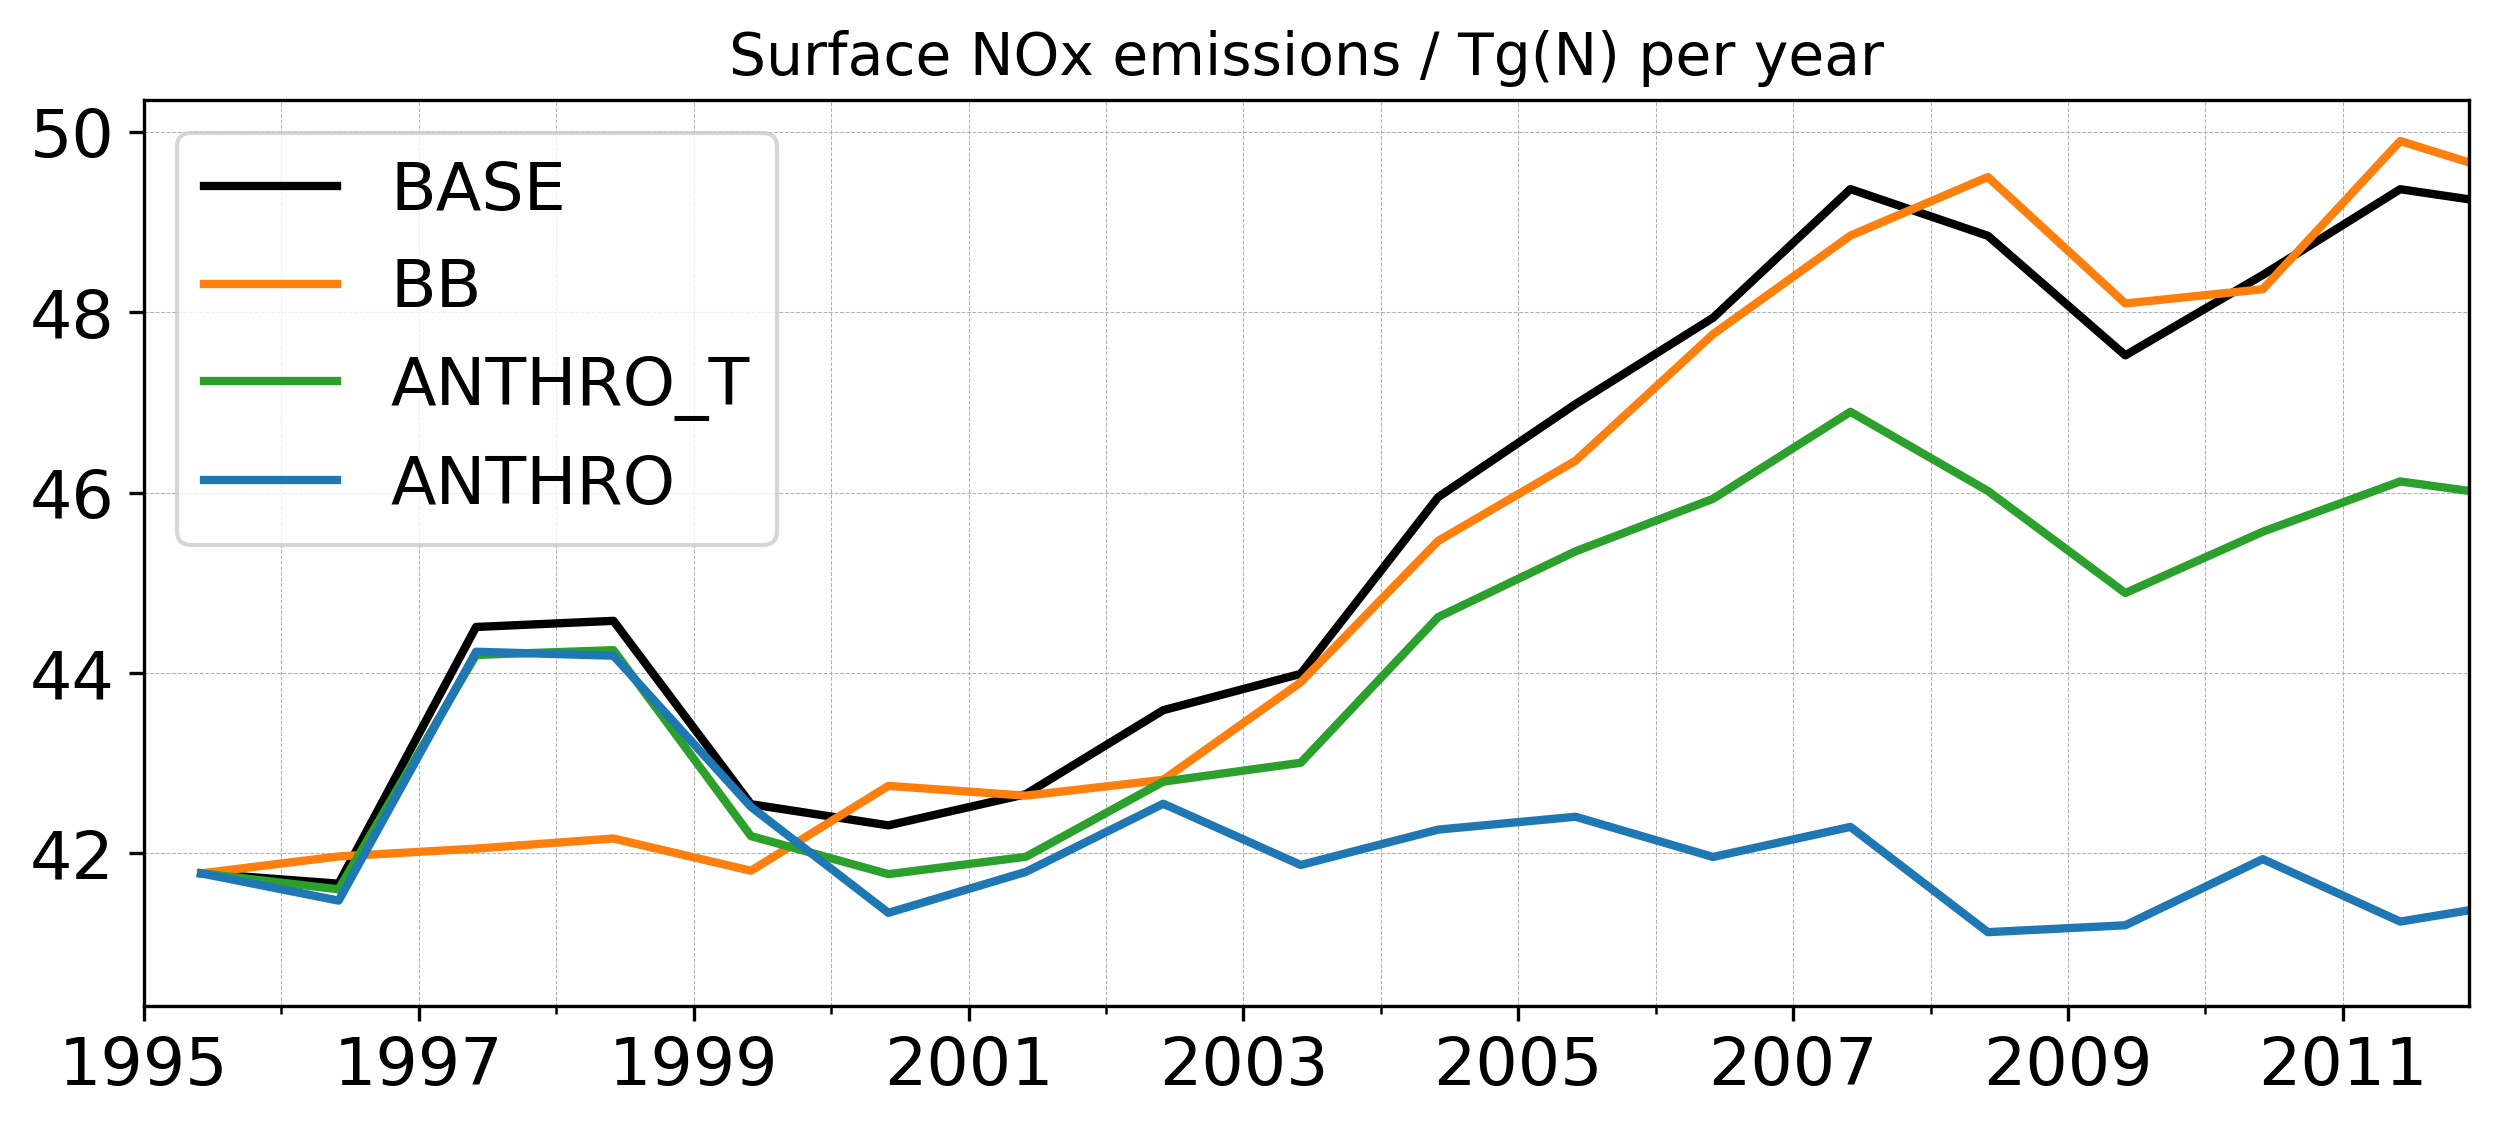

In [41]:
import datetime
cmap = plt.get_cmap("tab10")
fig=plt.figure(figsize=(10,4), dpi=300)
plt.subplot(1,1,1)
ax=(BASE['EMINOX']*30*24*3600/1e9*14/30).plot(color='k', label='BASE')
(BB['EMINOX']*30*24*3600/1e9*14/30).plot(color=cmap(1), label='BB')
(ANTHRO_T['EMINOX']*30*24*3600/1e9*14/30).plot(color=cmap(2), label='ANTHRO_T')
(ANTHRO['EMINOX']*30*24*3600/1e9*14/30).plot(color=cmap(0), label='ANTHRO')


ax.grid(True, which='both', linestyle='--', linewidth=0.25)
ax.set_xlim([datetime.date(1995, 1, 1), datetime.date(2011, 12, 31)])
plt.title('Surface NOx emissions / Tg(N) per year')
plt.legend()
